问题：较深的神经网络，反向传播，在靠前的网络层级处，梯度小，迭代慢。

解决：批量归一化

$$\mu_{B} = \frac{1}{\mathcal|B|}\sum_{i\in \mathcal B}x_{\mathcal i} $$
$$\sigma_{B}^{2} = \frac{1}{|\mathcal B|}\sum{(x_{i}-\mu_{B})^2}+\epsilon$$
$$x_{i+1} = \gamma \frac{x_i-\mu_B}{\sigma_B}+\beta$$

其中可以学习的参数为$\gamma$、$\beta$
- 一般在卷积/全连接层后，激活函数前面；或者全连接层和卷积层输入
- 对于全连接层，作用在特征维度；对于卷积层，作用在通道维度；
- 最初论文是想用它减少内部协变量转移
- 后续论文指出他可能是通过在每个小批量里面加入噪音【随即偏移和缩放】来控制模型复杂度
- 没必要和丢弃法混用
- 可以加快收敛速度，但一般不改变模型精度

"\mathcal"花体
$\mathcal N$ 高斯分布
$\mathcal L$ 损失函数
$\mathcal O$ 时间复杂度

"\mathbf"粗体
$\mathbf {abcd}$
$\mathbf abcd$

$\mu$
$\sigma$
$\gamma$
$\beta$
$\epsilon$

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
- 预测模式
    + 直接归一化
- 训练模式
    + 

IndentationError: unexpected indent (886103242.py, line 2)

torch.is_grad_enabled()
- checks whether gradient computation is enabled or disabled
- returns a boolean value indicating whether gradients are currently being tracked

torch.set_grad_enabled(False)
- computing gradients can be computationally expensive
- disable gradient tracking to improve performance

- Q:  
is it possible that one net is in prediction mode，yet another  
(the one we are processing) is in training mode, in this case, what result will it be? 

- A:  
The torch.is_grad_enabled() function returns a **global** state that determines  
whether gradient computation is enabled or disabled globally within the entire program,   
not specific to a particular network.


- **why use use exponential moving average to update the mean variance**    
to create a more stable estimate of the mean and variance  
by incorporating information from previous mini-batches

-  **assert len(X.shape) in (2,4)**  
The purpose of the assertion statement isto validate  
that X has either 2 or 4 dimensions. If X has any other number of dimensions, an assertion error will be raised

In [24]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): # 批量归一化操作,全局的均值和方差
    if not torch.is_grad_enabled():# 预测模式
       # used to determine whether the code is running in training mode or prediction mode
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2: # 使用全连接层的情况
            mean = X.mean(dim=0) # 计算后维度为(features)
            var = ((X-mean)**2).mean(dim=0)
        else: 
            # 使用二维卷积层的情况，计算通道上的均值和方差
            mean = X.mean(dim=(0,2,3), keepdim=True) # 计算后维度为(1,channels,1,1)
            var = ((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        # 训练模式下，用当前的均值方差做标准化
        X_hat = (X - mean)/torch.sqrt(var+eps)
        # 更新均值方差， 指数加权平均
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

- nn.Parameter()  
an initial scaling factor (gamma) of 1 and an initial shift factor (beta)  
a class in PyTorch that is used to define learnable parameters within a nn.Module

- X.device
- tensor.to(X.device)

- def forward(self, X):  
this is a necessity in a layer class definition

In [25]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 迭代参数
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X): 
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device!=X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
            
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.279, train acc 0.897, test acc 0.888
11985.3 examples/sec on cuda:0


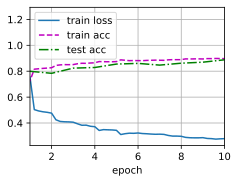

In [27]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [28]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))#取对应的参数并转为向量

(tensor([4.2899, 0.2303, 0.2605, 2.5817, 2.3651, 2.1766], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-2.1727,  0.4795,  0.0955,  2.9815, -2.8080,  1.1995], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

# 直接使用深度学习框架中定义的`BatchNorm`

In [ ]:
net = nn.Sequential(#使用nn.BatchNorm2d(特征维度)函数，pytorch会自动判断是对全连接层归一化还是卷积层归一化
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))